# Global Irminger Sea Array Profiler Mooring (GI02HYPM) Data Quality Report
**Evaluation Date**: 5/25/2018

**Evaluator**: Roos Bol

## Review Summary
This report summarizes a data quality review of the Global irminger Array Profiler Mooring (CP02PMUO).  We focus on CTD and oxygen data from July 2016 to July 2017 (Deployment 3), and compare the profiler's CTD with a cruise CTD collected on 12 July 2017, and with fixed-depth CTDs from the nearby surface mooring (GI01SUMO).

*This data quality report is mostly based on the OOI Example Data Quality Report by Sage Lichtenwalner, and Section 6 is based on an example script by Friedrich Knuth (Example 11: Deciphering OOI Data Quality Flags). Both files can be found in the GitHub repositiry of ooi-data-review [here](https://github.com/ooi-data-review/2018-data-workshops/tree/master/notebooks).*

## 1. Selected instruments included in this report
In this report, we will evaluate the CTD (specifically temperature and salinity) and oxygen data from the Global Irminger Array Profiler Mooring (GI02HYPM), focusing on the period from July 2016 to July 2017 (Deployment 3). 

Instrument | Reference Designator | Method | Stream 
 -- | -- | -- | --
CTD Profiler | [GI02HYPM-WFP02-04-CTDPFL000](http://ooi.visualocean.net/instruments/view/GI02HYPM-WFP02-04-CTDPFL000) | recovered_wfp | ctdpf_ckl_wfp_instrument_recovered
Dissolved Oxygen Profiler | [GI02HYPM-WFP02-03-DOSTAL000](http://ooi.visualocean.net/instruments/view/GI02HYPM-WFP02-03-DOSTAL000)  | recovered_wfp | dosta_ln_wfp_instrument_recovered


For comparison, we will also use data from a few of the fixed-depth CTDs, as well as wind speed data, from the nearby surface mooring GI01SUMO (see section 8 and 9 of this report):

Instrument | Reference Designator | Method | Stream 
 -- | -- | -- | --
 CTD (20m) |  [GI01SUMO-RII11-02-CTDMOQ011](http://ooi.visualocean.net/instruments/view/GI01SUMO-RII11-02-CTDMOQ011) | recovered_inst | ctdmo_ghqr_instrument_recovered
CTD (250 m) | [GI01SUMO-RII11-02-CTDMOQ015](http://ooi.visualocean.net/instruments/view/GI01SUMO-RII11-02-CTDMOQ015) | recovered_inst | ctdmo_ghqr_instrument_recovered
CTD (500 m) | [GI01SUMO-RII11-02-CTDMOQ017](http://ooi.visualocean.net/instruments/view/GI01SUMO-RII11-02-CTDMOQ017) | recovered_inst | ctdmo_ghqr_instrument_recovered
CTD (750 m) | [GI01SUMO-RII11-02-CTDMOR018](http://ooi.visualocean.net/instruments/view/GI01SUMO-RII11-02-CTDMOR018) | recovered_inst | ctdmo_ghqr_instrument_recovered
CTD (1000 m) | [GI01SUMO-RII11-02-CTDMOR019](http://ooi.visualocean.net/instruments/view/GI01SUMO-RII11-02-CTDMOR019) | recovered_inst | ctdmo_ghqr_instrument_recovered
CTD (1500 m) | [GI01SUMO-RII11-02-CTDMOR020](http://ooi.visualocean.net/instruments/view/GI01SUMO-RII11-02-CTDMOR020) | recovered_inst | ctdmo_ghqr_instrument_recovered
Bulk meteorology package (rel. wind speed only) | [GI01SUMO-SBD12-06-METBKA000](http://ooi.visualocean.net/streams/view/metbk_a_dcl_instrument_recovered) | recovered_host | metbk_a_dcl_instrument_recovered

CTD ond oxygen data from deployment 1 and 2 has been analysed and discussed in [this](https://tos.org/oceanography/article/deep-convection-in-the-irminger-sea-observed-with-a-dense-mooring-array) article in the *Oceanography - OOI Special Issue*. Therefore, we would like to have a look at the period after deployment 2, starting July 2016. Since the surface buoy lost all communications in October 2017, there is no telemetered data available for Deployment 4. In this report, we will therefore focus on deployment 3 only, from July 2016 to July 2017. Since the recovered data stream is already available, we will use the recovered data.

In [0]:
# Setup Instrument Variables
# for the CTD profiler:
site = 'GI02HYPM'
node = 'WFP02'
instrument = '04-CTDPFL000'
method = 'recovered_wfp'
stream = 'ctdpf_ckl_wfp_instrument_recovered'

# and for the oxygen profiler:
instrument_ox ='03-DOSTAL000'
method_ox = 'recovered_wfp'
stream_ox = 'dosta_ln_wfp_instrument_recovered'


## 2. Time periods of interest
We will focus on the following time periods for evaluation:
* July 11, 2016 to July 12, 2017 - All of Deployment 3 (see section 4a)
* The first 2 weeks of February 2017, where we observe a strange salinity profile (see section 4b)
* 20 June 2017 to 20 July 2017 - The period covering the changeover from Deployment 2 to 3 (see section 5), including the cruise CTD cast on July 12 (see section 7)


## 3. Related Metadata
In this section, we will review some of metadata available in the system to make sure it is present and correct.

Before we get started, we need to set up our Python environment with some libraries, variables and functions we will need later in this report.

In [63]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt

!pip install netCDF4
import netCDF4 as nc

!pip install xarray
import xarray as xr

!pip install cmocean
import cmocean


In [0]:
# API Information
USERNAME ='OOIAPI-OV6JB8EVZWNX0D'
TOKEN= 'TEMP-TOKEN-7SWE48C25H2540'
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'


In [0]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None


### 3a. Vocabulary Metadata
First, let's grab the basic vocabulary information (metadata) from the system to make sure we have the right instrument.

In [197]:
# Setup the API request url
data_request_url ='/'.join((VOCAB_API,site,node,instrument))
print data_request_url

# Grab the information from the server
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GI02HYPM/WFP02/04-CTDPFL000


[{u'@class': u'.VocabRecord',
  u'instrument': u'CTD',
  u'manufacturer': u'Sea-Bird',
  u'maxdepth': 2592.0,
  u'mindepth': 260.0,
  u'model': u'SBE 52MP',
  u'refdes': u'GI02HYPM-WFP02-04-CTDPFL000',
  u'tocL1': u'Global Irminger Sea',
  u'tocL2': u'Apex Profiler Mooring',
  u'tocL3': u'Wire-Following Profiler Upper',
  u'vocabId': 953}]

All this looks good!

### 3b. Deployment Information
Next, let's grab some information about the deployments for this instrument.  We will grab all of the deployments available in the system for 2017 and then output the date ranges, latitude/longitude, asset ID, and sensor ID for each.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the CTD on the Pioneer Upstream Offshore Profiler), the **Sensor ID** (and its Asset ID equivalent) represent the specific instrument used for a given deployment (i.e. a unique make, model, and serial numbered instrument).

In [6]:
# Setup the API request url
data_request_url = ASSET_API + '/events/deployment/query'
params = {
  'beginDT':'2016-01-01T00:00:00.000Z',
  'endDT':'2017-10-08T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
  
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1226.0,2.0,59.97275,-39.52348,CGINS-CTDPFL-00097,2015-08-16 22:59:00,2016-07-16 00:00:00
1,554.0,3.0,59.96950,-39.48860,CGINS-CTDPFL-00131,2016-07-11 14:22:00,2017-08-10 10:18:00
2,1226.0,4.0,59.97220,-39.53130,CGINS-CTDPFL-00097,2017-08-06 13:45:00,None


### 3c. Calibration Information
When the system delivers data, it often uses a number of calibration coefficients to generated derived data products.

It turns out that both the CTD and oxygen instrument don't have any calibration information, because none is required by the system.

Because the asset API can return confusing results, we will limit the search to just one day within the deployment time range.

In [22]:
# Setup the API request url
data_request_url = ASSET_API + '/asset/cal'
params = {
  'beginDT':'2017-07-01T00:00:00.000Z',
  'endDT':'2017-07-02T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,
} # for oxygen: change instrument to instrument_ox

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# see whether there is any calibration info by calling the first entry:
data[0]['sensor']


{u'@class': u'.XInstrument',
 u'assetId': 554,
 u'assetType': u'Sensor',
 u'calibration': [],
 u'dataSource': u'BulkLoad from [sensor_bulk_load-AssetRecord.csv]',
 u'deliveryDate': 1389744000000,
 u'deliveryOrderNumber': None,
 u'depthRating': None,
 u'description': u'CTD Profiler: CTDPF Series L',
 u'editPhase': u'OPERATIONAL',
 u'events': [],
 u'firmwareVersion': None,
 u'institutionPropertyNumber': None,
 u'institutionPurchaseOrderNumber': None,
 u'lastModifiedTimestamp': 1526905361118,
 u'location': None,
 u'manufacturer': u'Sea-Bird Electronics',
 u'mobile': False,
 u'modelNumber': u'SBE 52-MP',
 u'name': u'131',
 u'notes': None,
 u'ooiPartNumber': None,
 u'ooiPropertyNumber': None,
 u'ooiSerialNumber': None,
 u'owner': None,
 u'physicalInfo': {u'height': -1.0,
  u'length': -1.0,
  u'weight': -1.0,
  u'width': -1.0},
 u'powerRequirements': None,
 u'purchaseDate': 1389744000000,
 u'purchasePrice': None,
 u'remoteResources': [],
 u'serialNumber': u'131',
 u'shelfLifeExpirationDate':

As we can see from "u'calibration': [ ]'", there is no calibration information available for this instrument during this deployment.

If we would have calibration info, we would use the follwing code to read it:

In [0]:
# Reformat the data into a pretty table
# df = pd.DataFrame() # Setup empty array
# for d in data:
#  for dd in data['sensor']['calibration']
#   print dd
#     for ddd in dd['calData']:
#       df = df.append({
#         'value': ddd['value'],
#         'start': convert_time(ddd['eventStartTime']),
#         'stop': convert_time(ddd['eventStopTime']),
#         'name': ddd['eventName'],
#         'assetUid': ddd['assetUid'],
#         }, ignore_index=True)
    
# df = df.sort_values(by=['start','name'])
# df

### 3d. Annotations
Finally, let's pull any relevant annotations for the CTD instrument.

In [70]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2016,1,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,1,1).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument_ox,
} # for oxygen: change instrument to instrument_ox

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,Deployment 2: Profiler failed.,119.0,WFP02,None,GI02HYPM,2016-06-28 06:10:00,2016-07-16 00:00:00
1,Deployment 3: Profiler failed.,120.0,WFP02,None,GI02HYPM,2017-07-12 07:30:00,2017-08-10 10:18:00
2,Deployment 4: No data will be available via satellite telemetry for the remainder of the deployment. Data will be available when the mooring is recovered.,137.0,None,None,GI02HYPM,2017-08-27 00:00:00,None


There are three annotations in the system; these are the same for both for the CTD and the oxygen profiler data. The first two annotations tell us that the profiler has failed at the end of both deployment 2 and 3; this means there are two data gaps around the redeployments, from 2016-06-28	to 2016-07-16 (end of deployment 2) and from 2017-07-12 to 2017-08-10 (end of deployment 3). The third annotation tells us that no telemetered data will be availabe for deployment 4 from 2017-08-27 onwards. This is because the surface buoy smehow lost all communications. To retrieve this data, we will have to wait until the instruments have been recovered (expected: summer 2018). See also [this notice from OOI](http://oceanobservatories.org/2017/11/update-irminger-sea-surface-mooring-flyover-conducted/).

## 4. The full dataset
Now let's take a look at a large range of data.  We shall look at all of Deployment 3.

For simplicity, we used the Data Portal to make a download request for all available data.  After receiving the email, we looked through the results and here we specify just the netCDF file that includes the CTD data for all of deployment 3.  Using this data file, we will create a few different plots to better understand the available data.

In [0]:
# for the CTD data:
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/roos-bol-nioz/20180523T193411-GI02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_GI02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160712T000003-20170712T073020.999127.nc'

# Open the dataset
ds = xr.open_dataset(data_url)

# Swap the dimensions
ds = ds.swap_dims({'obs': 'time'})
#ds

In [0]:
# and do the same for the oxygen data:
data_url_ox = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/roos-bol-nioz/20180524T175125-GI02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0003_GI02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered_20160712T000207-20170712T072809.nc'
ds_ox = xr.open_dataset(data_url_ox)
ds_ox = ds_ox.swap_dims({'obs': 'time'})
#ds_ox

Let's create a quick timeseries plot of pressure.  If we plot the entire dataset, it will just be a blue blob, so let's just plot the first 100K points to see how the profiler works.

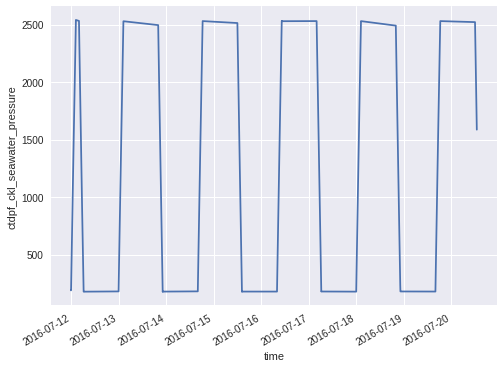

In [25]:
ds['ctdpf_ckl_seawater_pressure'][0:100000].plot();


It looks like the profiler travels between roughly 250 and 2500 meters depth, at a resolution of slightly less than a day. Between profiles, it stays at a fixed depth of either ~250 or ~2500m. 

Now, let's take a look at the full timeseries of temperature.  

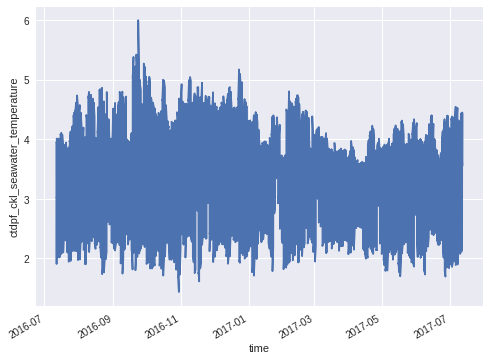

In [178]:
ds['ctdpf_ckl_seawater_temperature'].plot();

Next, let's create some histograms to see the full range of data.  (Thanks to xarray, this is easy to do in just one line!)  Histograms aren't really ideal for understanding a profiler dataset since all depths are included, but let's see what they looks like anyway.

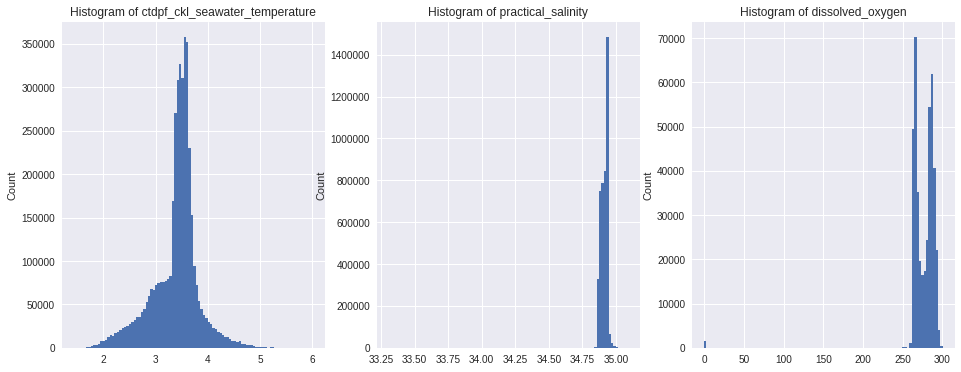

In [198]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6))
ds['ctdpf_ckl_seawater_temperature'].plot.hist(bins=100, ax=ax1)
ds['practical_salinity'].plot.hist(bins=100, ax=ax2)
ds_ox['dissolved_oxygen'].plot.hist(bins=100, ax=ax3);

The range of the data, as well as the general shape of the histograms, look as we would expect from the watermasses present in this region. The wide range of the x-axis for salinity and oxygen indicates that some outliers with very low values are likely present.  For the oxygen data, there seems to be a problem where several values have been detected as zero. 

So, let's create a profile timeseries to better understand the full dataset.

In [0]:
dtime = ds['time'].values
pressure = ds['ctdpf_ckl_seawater_pressure'].values
temperature = ds['ctdpf_ckl_seawater_temperature'].values
salinity = ds['practical_salinity'].values
density = ds['density'].values

dtime_ox = ds_ox['time'].values
pressure_ox = ds_ox['int_ctd_pressure'].values
oxygen = ds_ox['dissolved_oxygen'].values

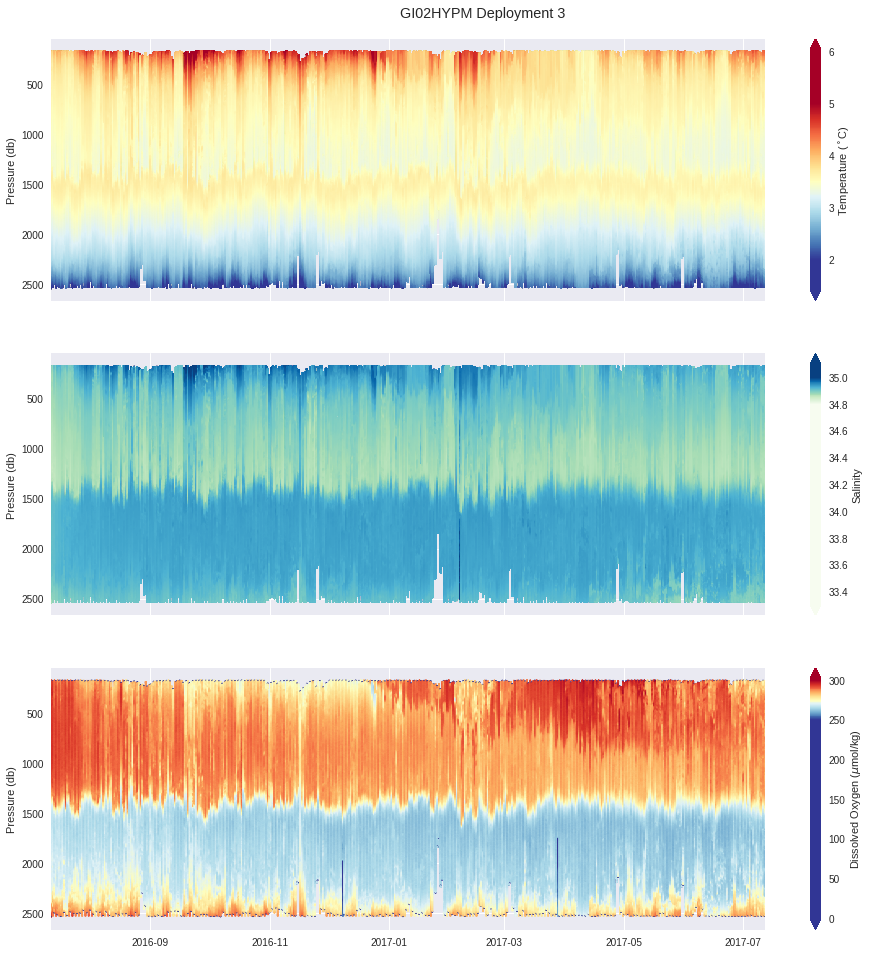

In [14]:
# Temperature, salinity and oxygen colorplot
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(16,15))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)
sc3 = ax3.scatter(dtime_ox, pressure_ox, c=oxygen, cmap='RdYlBu_r', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.set_clim(2,5)
#cbar.set_ylim(2,5)

cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (db)')

cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')
cbar.set_clim(34.8, 35)
#cbar.set_ylim(34.8, 35)

ax2.set_ylabel('Pressure (db)')

cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Dissolved Oxygen ($\mu$mol/kg)')
cbar.set_clim(250,300)
#cbar.set_ylim(250,300)

ax3.set_ylabel('Pressure (db)')

fig.suptitle('GI02HYPM Deployment 3')
fig.subplots_adjust(top=0.95);


This looks pretty good! We can see interesting stratification and mixed-layer dynamics in all three variables. There are no major gaps in the data, although in a few cases the profiler didn't make it all the way to the top or bottom. 
The 'zeros'  that we already observed in the oxygen histrogram seem to be occurring at the turn of the profiler, both at the top and bottom. Besides, we can observe some spikes in the oxygen and salinity data. For example, In the beginning of February, there seems to be a profile with anomalously low salinity values, perhaps due to some biofouling.  Let's have a closer look at this data:

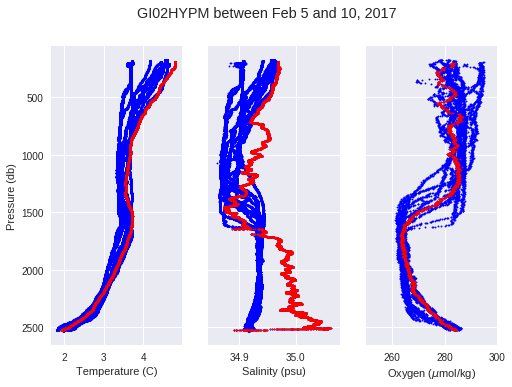

In [24]:
# Plot the first ten days of February; the suspicious profile of Feb 6 is plotted in red

ds1 = ds.loc[dict(time=slice('2017-02-01','2017-02-10'))]
ds1_ox = ds_ox.loc[dict(time=slice('2017-02-01','2017-02-10'))]

# ds 2 contains only the data on Feb 6:
ds2 = ds.loc[dict(time=slice('2017-02-06','2017-02-06'))]
ds2_ox = ds_ox.loc[dict(time=slice('2017-02-06','2017-02-06'))]


# plot:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.scatter(ds1['ctdpf_ckl_seawater_temperature'],ds1['ctdpf_ckl_seawater_pressure'],s=2,c='blue')
ax1.scatter(ds2['ctdpf_ckl_seawater_temperature'],ds2['ctdpf_ckl_seawater_pressure'],s=2,c='red')

ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (db)')
ax1.invert_yaxis()

ax2.scatter(ds1['practical_salinity'],ds1['ctdpf_ckl_seawater_pressure'],s=2,c='blue')
ax2.scatter(ds2['practical_salinity'],ds2['ctdpf_ckl_seawater_pressure'],s=2,c='red')
ax2.set_xlabel('Salinity (psu)')

ax3.scatter(ds1_ox['dissolved_oxygen'],ds1_ox['int_ctd_pressure'],s=2,c='blue')
ax3.scatter(ds2_ox['dissolved_oxygen'],ds2_ox['int_ctd_pressure'],s=2,c='red')
ax3.set_xlabel('Oxygen ($\mu$mol/kg)')
# because at the top & bottom of the profile, the oxygen sensor gives a value of 
# zero, we need to specify the xlimits:
ax3.set_xlim(250,300)


fig.suptitle('GI02HYPM between Feb 1 and 10, 2017');

It seems like only the salinity sensor detected a spike on the profile of February 6. Part of the profile is clearly wrong; however, it looks like the sensor magically recovered and was functioning normally again in the next profile. Perhaps some algae or particles were stuck on the sensor, or it might even have been a tiny octopus...

## 5. A closer look
Now let's look at one week around the switchover between Deployments 2 and 3.  In section 4, we used a netCDF file.  For this section, we will grab the data directly from the API using a synchronous request, which is limited to 20K datapoints. Note that with a synchronous request, we can easily retrieve data from multiple deployments at once, whereas with an asynchronous request as used above, we would have to download multiple netCDF files. 

We are interested in the switchover between deployment 2 and 3. The redeployment of the mooring took place on the 12th of July 2016; we will have a look at the data around this period, from June 20 to July 20. 

In [0]:
# Setup request for instrument data
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2016-06-20T00:00:00.000Z',
  'endDT':'2016-07-20T00:00:00.000Z',
  'limit':10000,
}

# Grab the CTD data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# and for oxygen:
data_request_url_ox ='/'.join((DATA_API,site,node,instrument_ox,method_ox,stream_ox))
r = requests.get(data_request_url_ox, params=params, auth=(USERNAME, TOKEN))
data_ox = r.json()

In [0]:
# Process the returned JSON dataset into something we can work with

# for the CTD data:
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])

# and oxygen:
p_ox = []
p_time_ox = []
p_pr_ox = []
for i in range(len(data_ox)):
  p_time_ox.append(ntp_seconds_to_datetime(data_ox[i]['time']))
  p_pr_ox.append(data_ox[i]['int_ctd_pressure'])
  p_ox.append(data_ox[i]['dissolved_oxygen']) 


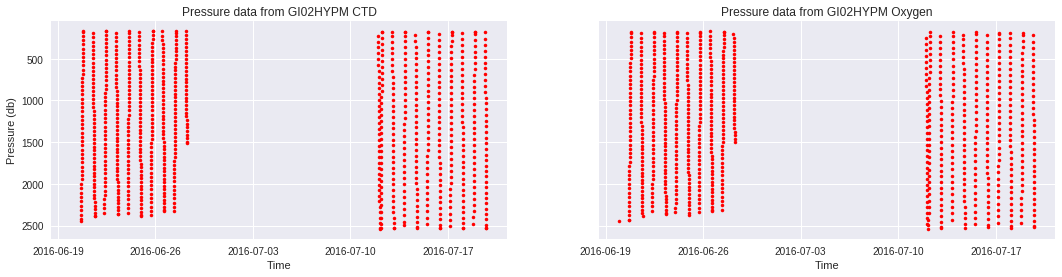

In [38]:
# First, let's make a timeseries of pressure
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, sharex=True,figsize=(18,4))

ax1.plot_date(p_time,p_pr,'r.')
ax1.set_title('Pressure data from GI02HYPM CTD')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pressure (db)')
ax1.invert_yaxis()

ax2.plot_date(p_time_ox,p_pr_ox,'r.')
ax2.set_title('Pressure data from GI02HYPM Oxygen');
ax2.set_xlabel('Time');


As noted in the annotation above, the profiler failed near the end of deployment 2 on June 28, 2017.  Thus, we have a gap of about two weeks in the data for the remained of this deployment, until the mooring is redeployed for Deployment 3 on the 12th of July.

For another perspective, let's take a look a look at the temperature, salinity and oxygen vertical profiles around this period. 

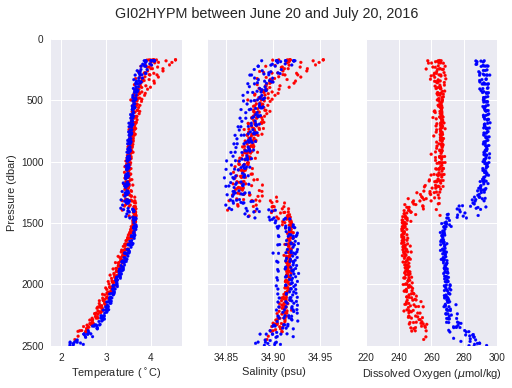

In [39]:
# Profile plots of temperature, salinity and oxygen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# Create a color map to divide the two deployments
kcolors = ['red' if t<datetime.datetime(2016,07,12,00,00,00) else 'blue' for t in p_time]
kcolors_ox = ['red' if t<datetime.datetime(2016,07,12,00,00,00) else 'blue' for t in p_time_ox]


ax1.scatter(p_temp,p_pr, c=kcolors, s=8)
# ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_ylim(2500,0)

ax2.scatter(p_sal,p_pr, c=kcolors, s=8)
ax2.set_xlabel('Salinity (psu)')

ax3.scatter(p_ox,p_pr_ox, c=kcolors_ox, s=8)
ax3.set_xlabel('Dissolved Oxygen ($\mu$mol/kg)')
ax3.set_xlim(220,300)

fig.suptitle('GI02HYPM between June 20 and July 20, 2016')
fig.subplots_adjust(top=0.9);


Data before the redeployment is plotting in red, and after is blue. All three sensors seem to show an offset between the two deployments. This is most visible in the oxygen profiles. However, considering that in this region, small temperature and salinity variations can already have a large impact, we can conclude that for all three sensors further calibration is necessary.  

**Dissolved Oxygen data portal quick-plot**

When downloading data from the data portal, it is always useful to have a first look at the data plot and see whether your data is available and whether you can already observe any majpor issues. 
In our case, we could already observe the offset between the data from the two oxygen deploymenys in the plot of the data portal, as can be seen [here](https://drive.google.com/file/d/15rxFiaMaaLn4_r39395-qTXHe5qcSvJ-/view?usp=sharing).




##6. OOI Quality Control Algorithms 

Basic quality control algorithms have been applied to the data, resulting in quality flags. The variables ending in [...]_qc_executed indiate which tests have been performed, and the variables ending in [...]_qc_results give the results of these QC tests for each specific datapoint. 

Again, we will request the full dataset, but now using a synchronous request directly to the M2M API. Note that this is limited to 20K datapoints. Let's once again look at the first 10 days of February 2017, since we already know that this period contains a strange salinity profile.

In [0]:
# Setup request for instrument data
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-02-01T00:00:00.000Z',
  'endDT':'2017-02-10T00:00:00.000Z',
  'limit':20000,
}

# Grab the CTD data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# convert to a panda dataframe for easy access & plotting:
df = pd.DataFrame.from_records(map(json.loads, map(json.dumps,data)))
# convert the timestamp
df['time'] = pd.to_datetime(df['time'], unit='s', origin=pd.Timestamp('1900-01-01'))

In [0]:
# and for oxygen:
data_request_url_ox ='/'.join((DATA_API,site,node,instrument_ox,method_ox,stream_ox))
r = requests.get(data_request_url_ox, params=params, auth=(USERNAME, TOKEN))
data_ox = r.json()

df_ox = pd.DataFrame.from_records(map(json.loads, map(json.dumps,data_ox)))
df_ox['time'] = pd.to_datetime(df_ox['time'], unit='s', origin=pd.Timestamp('1900-01-01'))

Now, let's first quickly check what the data looks like:

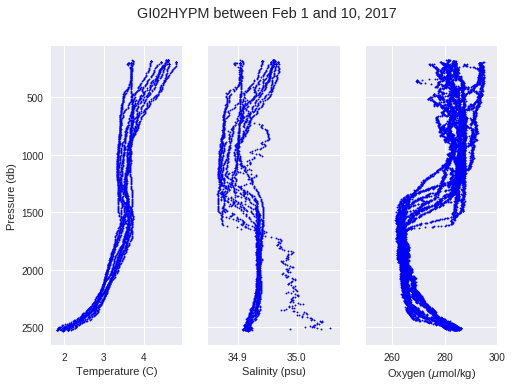

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.scatter(df['ctdpf_ckl_seawater_temperature'],df['ctdpf_ckl_seawater_pressure'],s=2,c='blue')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (db)')
ax1.invert_yaxis()

ax2.scatter(df['practical_salinity'],df['ctdpf_ckl_seawater_pressure'],s=2,c='blue')
ax2.set_xlabel('Salinity (psu)')

ax3.scatter(df_ox['dissolved_oxygen'],df_ox['int_ctd_pressure'],s=2,c='blue')
ax3.set_xlabel('Oxygen ($\mu$mol/kg)')
ax3.set_xlim(250,300)

fig.suptitle('GI02HYPM between Feb 1 and 10, 2017');

Good, this looks as expected! Now, let's turn to the quality control variables.

In [0]:
# Extract only the relevant QC variables from the dataframe
df=df[['time', 'ctdpf_ckl_seawater_pressure', 'ctdpf_ckl_seawater_pressure_qc_executed', 'ctdpf_ckl_seawater_pressure_qc_results',
          'ctdpf_ckl_seawater_temperature', 'ctdpf_ckl_seawater_temperature_qc_executed', 'ctdpf_ckl_seawater_temperature_qc_results',
          'ctdpf_ckl_seawater_conductivity', 'ctdpf_ckl_seawater_conductivity_qc_executed', 'ctdpf_ckl_seawater_conductivity_qc_results']]
# and have a look at the first few entries:
df.head()

,time,ctdpf_ckl_seawater_pressure,ctdpf_ckl_seawater_pressure_qc_executed,ctdpf_ckl_seawater_pressure_qc_results,ctdpf_ckl_seawater_temperature,ctdpf_ckl_seawater_temperature_qc_executed,ctdpf_ckl_seawater_temperature_qc_results,ctdpf_ckl_seawater_conductivity,ctdpf_ckl_seawater_conductivity_qc_executed,ctdpf_ckl_seawater_conductivity_qc_results
0,2017-01-31 14:28:57.998768,177.19,29,29,3.7020,29,29,3.22882,29,29
1,2017-02-01 08:00:02.000000,202.66,29,29,3.6055,29,29,3.22052,29,29
2,2017-02-01 08:00:11.008683,202.88,29,29,3.6250,29,29,3.22240,29,29
3,2017-02-01 08:00:50.046312,202.44,29,29,3.6216,29,29,3.22208,29,29
4,2017-02-01 08:01:29.083941,202.46,29,29,3.6117,29,29,3.22153,29,29


In [0]:
# same for the oxygen data:
df_ox=df_ox[['time', 'int_ctd_pressure', 'dissolved_oxygen','dissolved_oxygen_qc_executed', 'dissolved_oxygen_qc_results']]

df_ox.head()

,time,int_ctd_pressure,dissolved_oxygen,dissolved_oxygen_qc_executed,dissolved_oxygen_qc_results
0,2017-02-01 08:02:03,203.547834,0.000000,29,29
1,2017-02-01 08:02:13,205.100237,0.000000,29,29
2,2017-02-01 08:02:23,207.515855,0.000000,29,29
3,2017-02-01 08:02:36,210.656159,288.390766,29,29
4,2017-02-01 08:02:46,213.071777,287.317491,29,29


We can see that most of the time, both qc_executed and qc_results display the value 29. This is because the different QC flags are 
The QC flags for all tests are OR'd together to produce a single value for each data point. To understand which tests were performed, we need to translate this value back to the orgingral bits. 

The summed QC tests are summarized in this table:


Test name | <td colspan=16> **Bit position**  
 -- | -- 
                                                       | 15 | 14 | 13 | 12 | 11 | 10 | 9 | 8 | 7 | 6 | 5 | 4 | 3 | 2 | 1 | 0
global_range_test |         0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1
dataqc_localrangetest |     0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0
dataqc_spiketest |          0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0
dataqc_polytrendtest |      0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0
dataqc_stuckvaluetest |     0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0
dataqc_gradienttest |       0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0
dataqc_propagateflags |     0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0
  
(More info on the different tests can be found on the [OOI website Quality Control section](http://oceanobservatories.org/quality-control/)).


So, given a qc_executed value of 29 we can see which tests were run by translating this value back to bits:

In [0]:
np.unpackbits(np.array(29).astype('uint8'))

array([0, 0, 0, 1, 1, 1, 0, 1], dtype=uint8)

If you compare this result, [0, 0, 0, 1, 1, 1, 0, 1], to the table above, you can see that a value of 29 indicates that the executed tests are:
* global_range_test
* dataqc_spiketest
* dataqc_polytrendtest
* dataqc_stuckvaluetest

We can craft a function to create new booleans variables for each test run containing the pass/fail results from that test:

In [0]:
def parse_qc(df):
    vars = [x.split('_qc_results')[0] for x in df.columns if 'qc_results' in x]
    results = [x+'_qc_results' for x in vars]
    executed = [x+'_qc_executed' for x in vars]
    key_list = vars + results + executed

    for var in vars:
        qc_result = var + '_qc_results'
        qc_executed = var + '_qc_executed'
        names = {
            0: var + '_global_range_test',
            1: var + '_dataqc_localrangetest',
            2: var + '_dataqc_spiketest',
            3: var + '_dataqc_polytrendtest',
            4: var + '_dataqc_stuckvaluetest',
            5: var + '_dataqc_gradienttest',
            7: var + '_dataqc_propagateflags',
        }
        # Just in case a different set of tests were run on some datapoint. *This should never happen*
        executed = np.bitwise_or.reduce(df[qc_executed].values)
        executed_bits = np.unpackbits(executed.astype('uint8'))
        for index, value in enumerate(executed_bits[::-1]):
            if value:
                name = names.get(index)
                mask = 2 ** index
                values = (df[qc_result].values & mask) > 0
                df[name] = values
        df.drop([qc_executed, qc_result], axis=1, inplace=True)
    return df

Run the function. The result gives us the QC algorithm result for every data point. True = test passed.

In [0]:
df_qc = parse_qc(df)
df_qc.head()

,time,ctdpf_ckl_seawater_pressure,ctdpf_ckl_seawater_temperature,ctdpf_ckl_seawater_conductivity,ctdpf_ckl_seawater_pressure_global_range_test,ctdpf_ckl_seawater_pressure_dataqc_spiketest,ctdpf_ckl_seawater_pressure_dataqc_polytrendtest,ctdpf_ckl_seawater_pressure_dataqc_stuckvaluetest,ctdpf_ckl_seawater_temperature_global_range_test,ctdpf_ckl_seawater_temperature_dataqc_spiketest,ctdpf_ckl_seawater_temperature_dataqc_polytrendtest,ctdpf_ckl_seawater_temperature_dataqc_stuckvaluetest,ctdpf_ckl_seawater_conductivity_global_range_test,ctdpf_ckl_seawater_conductivity_dataqc_spiketest,ctdpf_ckl_seawater_conductivity_dataqc_polytrendtest,ctdpf_ckl_seawater_conductivity_dataqc_stuckvaluetest
0,2017-01-31 14:28:57.998768,177.19,3.7020,3.22882,True,True,True,True,True,True,True,True,True,True,True,True
1,2017-02-01 08:00:02.000000,202.66,3.6055,3.22052,True,True,True,True,True,True,True,True,True,True,True,True
2,2017-02-01 08:00:11.008683,202.88,3.6250,3.22240,True,True,True,True,True,True,True,True,True,True,True,True
3,2017-02-01 08:00:50.046312,202.44,3.6216,3.22208,True,True,True,True,True,True,True,True,True,True,True,True
4,2017-02-01 08:01:29.083941,202.46,3.6117,3.22153,True,True,True,True,True,True,True,True,True,True,True,True


In [0]:
# and for oxygen:
df_ox_qc = parse_qc(df_ox)
df_ox_qc.head()

,time,int_ctd_pressure,dissolved_oxygen,dissolved_oxygen_global_range_test,dissolved_oxygen_dataqc_spiketest,dissolved_oxygen_dataqc_polytrendtest,dissolved_oxygen_dataqc_stuckvaluetest
0,2017-02-01 08:02:03,203.547834,0.000000,True,True,True,True
1,2017-02-01 08:02:13,205.100237,0.000000,True,True,True,True
2,2017-02-01 08:02:23,207.515855,0.000000,True,True,True,True
3,2017-02-01 08:02:36,210.656159,288.390766,True,True,True,True
4,2017-02-01 08:02:46,213.071777,287.317491,True,True,True,True


As you can see from the last table, unfortunately, the zeros in the oxygen data have not been flagged by any of the tests. 

Now, let's have look at both the oxygen and CTD data points that were flagged by any of the tests:

In [0]:
# oxygen flagged points:
qc_cols = [col for col in df_ox_qc.columns if 'test' in col]
result = df_ox_qc[(df_ox_qc[qc_cols[0]] == False) | (df_ox_qc[qc_cols[1]] == False) | (df_ox_qc[qc_cols[2]] == False) | (df_ox_qc[qc_cols[3]] == False)]

print(result.to_string())


Empty DataFrame
Columns: [time, int_ctd_pressure, dissolved_oxygen, dissolved_oxygen_global_range_test, dissolved_oxygen_dataqc_spiketest, dissolved_oxygen_dataqc_polytrendtest, dissolved_oxygen_dataqc_stuckvaluetest]
Index: []


In [0]:
# CTD flagged points:
qc_cols = [col for col in df_qc.columns if 'test' in col]
result = df_qc[(df_qc[qc_cols[0]] == False) | (df_qc[qc_cols[1]] == False) | (df_qc[qc_cols[2]] == False) | (df_qc[qc_cols[3]] == False)]

print(result.to_string())

Empty DataFrame
Columns: [time, ctdpf_ckl_seawater_pressure, ctdpf_ckl_seawater_temperature, ctdpf_ckl_seawater_conductivity, ctdpf_ckl_seawater_pressure_global_range_test, ctdpf_ckl_seawater_pressure_dataqc_spiketest, ctdpf_ckl_seawater_pressure_dataqc_polytrendtest, ctdpf_ckl_seawater_pressure_dataqc_stuckvaluetest, ctdpf_ckl_seawater_temperature_global_range_test, ctdpf_ckl_seawater_temperature_dataqc_spiketest, ctdpf_ckl_seawater_temperature_dataqc_polytrendtest, ctdpf_ckl_seawater_temperature_dataqc_stuckvaluetest, ctdpf_ckl_seawater_conductivity_global_range_test, ctdpf_ckl_seawater_conductivity_dataqc_spiketest, ctdpf_ckl_seawater_conductivity_dataqc_polytrendtest, ctdpf_ckl_seawater_conductivity_dataqc_stuckvaluetest]
Index: []


In both cases, the result is an empty dataframe, meaning that no values were flagged by the QC tests. Since we have observed several different kinds of spikes, this means that we, as user of the data, definitely still need to perform some extra QC.

## 7. Comparison with a shipboard CTD
Next, we compare the profiler's CTD with data collected during the Irminger 3 Deployment Cruise, AR07-01, cast #7, 11 Jul 2016 19:29 UTC. We will compare the cruise CTD data with the profiler data on the following day (July 12), after the redeployment, because of the data gap discussed above.

Unfortunately, the Irminger Sea 4 Deployment Cruise, AR21,  cast 008 on 2017/08/06, 14:44 UTC, lies outside of the range of availabe recovered data for GI02HYPM, because of the data gap discussed in annotation #1 (section 3d).

The raw ascii data files for the CTD cast can be found at the following location:

In [0]:
# First, specify the data file for the cruise CTD cast
# Downcast
# cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/ef3f532b-7570-43d9-b016-6b58c4429b15/dar24011.asc'
# Down and Up Casts
cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/1d45a9bd-59b6-4f26-aa11-12cdf01c8ca3/ar0701007.asc'
# Read in the data file without headers due to a bug in the file (two of the header names run together)
cruise_data = pd.read_table(cruise_data_file, delim_whitespace=True, header=None, skiprows=1)

# Add back the necessary headers
cruise_data = cruise_data.rename(columns={0:'Pressure', 1:'Temperature', 15:'Salinity', 16:'Oxygen'})


In [0]:
# Next let's grab the Profiler data using a synchronous request 
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2016-07-11T00:00:00.000Z',
  'endDT':'2016-07-13T00:00:00.000Z',
  'limit':1000,
}
# note that we take data from the 12th of July as well, because there is no data available for July 11

# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# And the same for dissolved oxygen:
data_request_url ='/'.join((DATA_API,site,node,instrument_ox,method_ox,stream_ox))
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data_ox = r.json()


In [0]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []

for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])

p_ox = []
p_time_ox = []
p_pr_ox = [] 

for i in range(len(data_ox)):
  p_pr_ox.append(data_ox[i]['int_ctd_pressure'])
  # for oxygen: cruise data is in mL/L, but mooring data in mumol/kg
  # to convert units, we multiply the mooring data by 0.022391*1.025
  p_ox.append(0.022391*1.025*data_ox[i]['dissolved_oxygen']) 
  p_time_ox.append(ntp_seconds_to_datetime(data_ox[i]['time']))


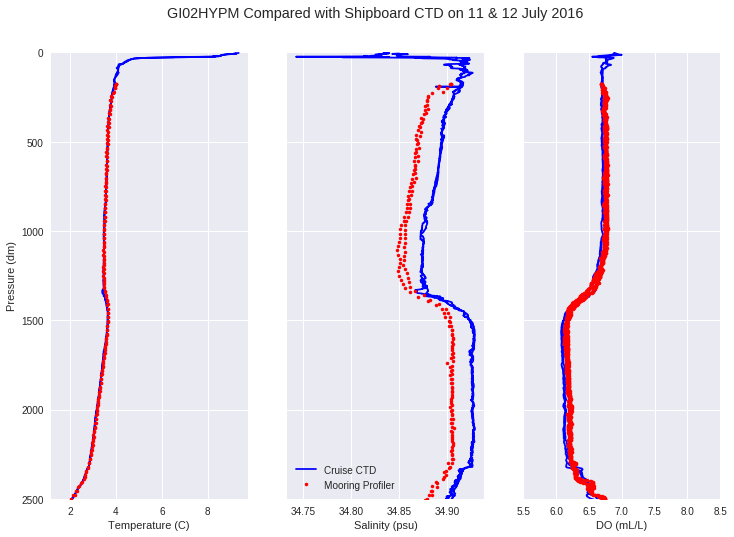

In [72]:
# Now let's plot the Cruise and Profiler data together
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(12,8))

ax1.plot(cruise_data.Temperature,cruise_data.Pressure,'b')
ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
# ax1.invert_yaxis()
ax1.set_ylim(2500,0)

ax2.plot(cruise_data.Salinity,cruise_data.Pressure,'b',label='Cruise CTD')
ax2.plot(p_sal,p_pr,'r.',label='Mooring Profiler')
ax2.set_xlabel('Salinity (psu)')

ax3.plot(cruise_data.Oxygen,cruise_data.Pressure,'b',label='Cruise CTD')
ax3.plot(p_ox,p_pr_ox,'r.',label='Mooring Profiler')
ax3.set_xlabel('DO (mL/L)')
ax3.set_xlim(5.5,8.5)


fig.suptitle('GI02HYPM Compared with Shipboard CTD on 11 & 12 July 2016')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower left', shadow=True, fontsize='small');


The temperature and oxygen profiler data line up nicely with the cruise data. For salinity, however, therre is clearly an offset between the mooring and the cruise data, and calibration of the instruments is clearly necessary.

## 8. Comparison with some nearby fixed-depth CTDs

The Irminger array Profiler and Surface Mooring are located only 4 km apart. Therefore, another way to validate our profiler data would be to use the CTD data from the Apex Surface Mooring GI01SUMO. We will use CTD data from this mooring at 6 different depths. Below, we request this data through using a synchronous API request and compare it to our profiler data.

As a study period we now choose a one-month period in early 2017, from 10 Jan to 10 Feb.

In [0]:
# Setup Instrument Variables
site2 = 'GI01SUMO'
node2 = 'RII11'
instrument2 = '02-CTDMOQ011','02-CTDMOQ015', '02-CTDMOQ017', '02-CTDMOR018', '02-CTDMOR019', '02-CTDMOR020'
method2 = 'recovered_inst'
stream2 = 'ctdmo_ghqr_instrument_recovered'

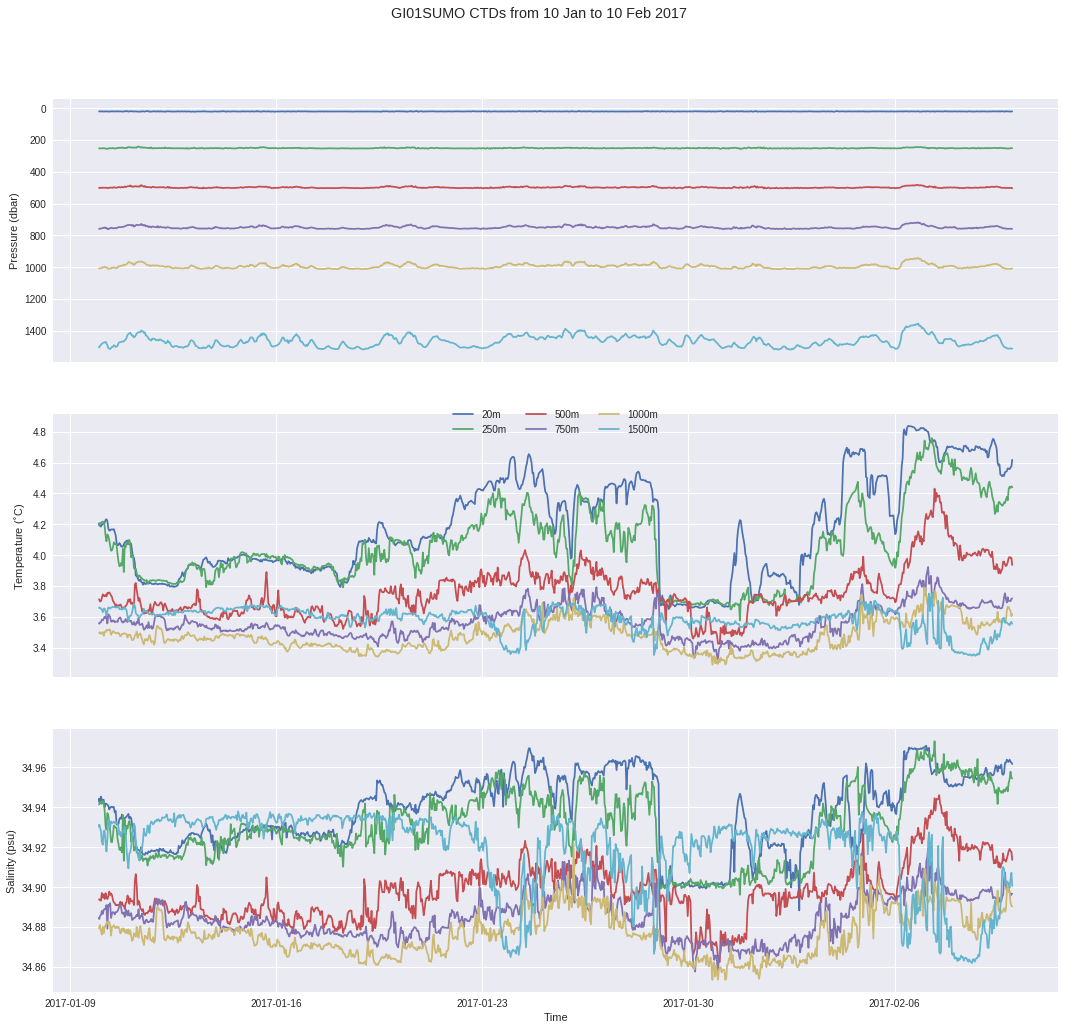

In [61]:
# Setup request for instrument data
params = {
  'beginDT':'2017-01-10T00:00:00.000Z',
  'endDT':'2017-02-10T00:00:00.000Z',
  'limit':1000,
}

depths = ['20m','250m', '500m', '750m', '1000m', '1500m']

# create a figure
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True,figsize=(18,16))

# loop over the 5 CTD instruments
for inst in instrument2:
  data_request_url ='/'.join((DATA_API,site2,node2,inst,method2,stream2))
  # Grab the CTD data
  r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
  data = r.json()
  
  # convert to a panda dataframe for easy access & plotting:
  df2 = pd.DataFrame.from_records(map(json.loads, map(json.dumps,data)))
  # convert the timestamp
  df2['time'] = pd.to_datetime(df2['time'], unit='s', origin=pd.Timestamp('1900-01-01'))
  
  # add data to the plot  
  ax1.plot(df2['time'],df2['ctdmo_seawater_pressure'])
  ax1.set_ylabel('Pressure (dbar)')
  
  ax2.plot(df2['time'],df2['ctdmo_seawater_temperature'])
  ax2.set_ylabel('Temperature ($^{\circ}$C)')

  ax3.plot(df2['time'],df2['practical_salinity'])
  ax3.set_ylabel('Salinity (psu)')
  ax3.set_xlabel('Time')
  
ax1.invert_yaxis()
ax2.legend(depths,loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3)
fig.suptitle('GI01SUMO CTDs from 10 Jan to 10 Feb 2017')
fig.subplots_adjust(top=0.9);

This is another way to visualize the stratification. For example, in the temperature plots, we can see that in the last week of January, the mixed-layer reaches until ~750m depth. It seems as if a big storm passed by around Jan 31, removing the stratification of the surface layer.

Interestingly, on the 6th of February - the day on which we observed a strange salinity profile in the GI02 profiler CTD data - conditions seems to have changed drastically in the GI01 site as well, as restraification set in.

## 9. Wind forcing

Wind forcing plays a very important role in this region. The surface mooring GI01SUMO has a bulk meteorlogy package (metbk) that provides us with many different meteorological parameters. For now, we are just interested in the wind speed data, given on an hourly resolution. 
As in section 4, we have requested all the available data from the data portal. Below, we use the link received by email and specify just the netCDF file that includes the wind speed data for deployment 3. 

In [0]:
# Downloaded stream: GI01SUMO-SBD12-06-METBKA000

# get the data from the URL available by downloading through the data portal
data_url_ws = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/roos-bol-nioz/20180530T151956-GI01SUMO-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0003_GI01SUMO-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20160710T174427.001000-20170812T205458.035000.nc'
ds_ws = xr.open_dataset(data_url_ws)
ds_ws = ds_ws.swap_dims({'obs': 'time'})



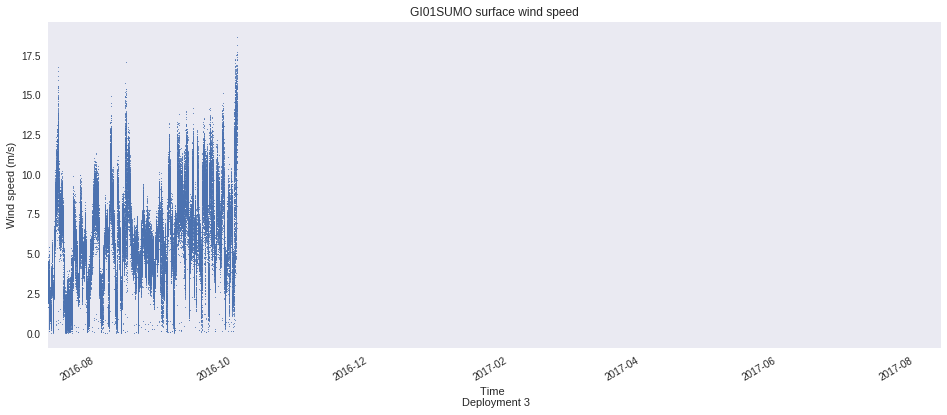

In [86]:
# plot the timeseries of wind speed
fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds_ws['met_relwind_speed'].plot(linestyle = 'None', 
                                   marker='.', 
                                   markersize=2,
                                   ax=ax)
ax.grid()
plt.title('GI01SUMO surface wind speed')
plt.ylabel('Wind speed (m/s)')
plt.xlabel('Time \n Deployment 3')
plt.xlim(ds_ws['time'].values[0],ds_ws['time'].values[-1])
plt.show();


That seems like there is a lot of missing data - let's also pull up the annotations:

In [87]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2016,7,12).strftime('%s'))*1000,
  'endDT':int(datetime.date(2017,7,12).strftime('%s'))*1000,
  'refdes':'GI01SUMO-SBD12-06-METBKA000',
} # for oxygen: change instrument to instrument_ox

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,"Deployment 2: A period of violent weather caused power outages on multiple instruments. No telemetered or recovered_host data expected. Functional instruments could continue to collect data using internal battery power and storage cards. Upon recovery, the buoy well was flooded.",47.0,None,None,GI01SUMO,2016-01-27 00:00:00,2016-07-19
1,"Deployment 2: Anemometer placement was corrected from Deployment 1, but wind speeds may still be low-biased (5-10%) at speeds > 5 m/s, as determined by comparisons with ship measurements and measurements from the FDCHP.",111.0,SBD12,06-METBKA000,GI01SUMO,2015-08-15 19:22:00,2016-07-19
2,"Deployment 3: Wind turbines were disabled due to evidence of ice build-up on the surface buoy tower. The platform's battery charge state declined steadily. As of 2017-01-15, all DCLs were shut down and the telemetry schedule was reduced to conserve power. Battery-powered instruments should continue to collect data. UPDATE 2017-04-07: With increasing daylight at this location, sufficient power was generated by solar panels to re-establish limited high-bandwidth telemetry and data transmission. UPDATE: at recovery, wind turbines were missing their hubs and blades, and one solar panel was missing.",121.0,None,None,GI01SUMO,2016-12-27 00:00:00,2017-04-07


As noted by the annotations, there have been a few issues with the bulk meteorology data from this buoy due to ice and storm damage. However, from the annotations (as well as from the data portal data availability plot) we can tell that there should be data available from mid-July until the end of December 2016, as well as from April 2017 onwards. It seems like an extra annotation should be added to indicate that a larger fraction of the data is missing.

## 10. Notable Results and Actions Needed

* Overall, the GI02HYPM proflier CTD and O2 data for deployment 3 (jul 2016 - Jul 2017) looks pretty good, with no big data gaps or very large outliers. The profiles show what we would generally expect for this region: 
  * recently ventilated waters (by deep convection) near the surface
  * colder, higher salinity, lower oxygen waters at depth, originating from the Nordic overflows
* From a first look at the data, it seems as if in the winter of 2016-2017, convective mixing did not penetrate as deep as in the previous two winters.
* No calibration or flagged data is yet available for thr GI02HYPM profiler data:
  * Some spikes were observed, especially in the oxygen and salinity data, indicating that the data needs some cleaning/filtering 
  * From comparison of the profiler data with a cruise CTD cast, we can clearly see that calibration of the instruments is necessary, especially for salinity
  * Quality control tests provided by the OOI did not flag the detected outliers
* Comparison of the GI02HYPM profiler data with a cruise CTD cast in July 2017 showed generally good agreement for oxygen and temperature, not so good for oxygen:
  * Important to note the different units for oxygen: $\mu$mol/kg in mooring CTD data, mL/L in cruise CTD data
  * Cruise data variable names are unclear in some cases: for example, there are 3 different salinity variables in the cruise data file, that all seem to contain the same data
* For the Metbk package of the GI01SUMO (variable: relative wind speed), the data portal seems to show incomplete information concerning data availability